# Generalised Empirical Interpolation Method: sensor placement
This notebook takes the Snapshots and places the sensors using the Generalised Empirical Interpolation Method (GEIM).

Let us create the mesh from the OpenFOAM nodes and cells

In [1]:
from pyforce.tools.write_read import ReadFromOF

path_snaps = '../../../Data/MSFR/'

of = ReadFromOF(path_snaps+'ULOFF-reflector/', mode='pyvista')
domain = of.create_mesh()

  warnings.warn('The mesh contains more than one cell type.')



Hexahedron cells selected


Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('Results/times.npz')['fom_times']

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1))
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us define the boundary-tags at which sensors will be placed

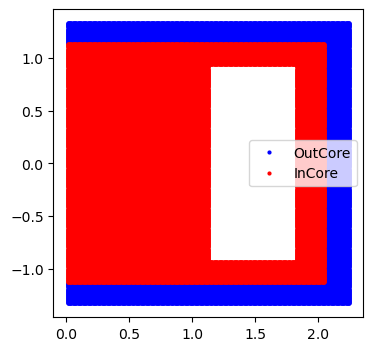

In [3]:
def is_out_core(node):
    return ((node[2] <= -1.13) or 
            (node[2] >=  1.13) or (node[0] >= 2.05))

nodes = domain.geometry.x
out_core = np.array([is_out_core(node) for node in nodes])
out_core_idx = np.where(out_core)[0]
in_core_idx  = np.where(~out_core)[0]

import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(4, 4))
plt.plot(nodes[out_core_idx, 0], nodes[out_core_idx, 2], 'bo', markersize=2, label='OutCore')
plt.plot(nodes[in_core_idx, 0], nodes[in_core_idx, 2], 'ro', markersize=2, label='InCore')
plt.legend()


Let us split the snapshots into train, test and predict: predict include times $t>50$ seconds, train and test include times $t<50$ seconds, these are randomly selected.

In [7]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)
cut_train = int(0.9*Nt)

_indices = np.arange(0, cut_train)
train_indices, test_indices = train_test_split(_indices, test_size=0.2, random_state=42)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

measured_field_i = 1
train_snaps = FunctionsList(fun_spaces[measured_field_i])
for ii in train_indices:
    train_snaps.append(snaps[var_names[measured_field_i]](ii) / snaps[var_names[measured_field_i]](0).max())

Let us define the available sensor positions. Three strategies are available:
1. No constraints (ID)
2. Constrained to the full boundary (BF)
3. Constrained to the true boundary (BP) - no symmetry

In [ ]:
xm_list = {
    'ID': None,
    'Out': list()
}

for tag in out_core_idx[::20]: # sampling to reduce the computational time
    xm_list['Out'].append(nodes[tag])

sample_every = 40
s = 0.025

## GEIM Training Phase
Let us define the training phase of the GEIM.

In [21]:
from pyforce.offline.geim import GEIM

geim_offline = {
    strategy: GEIM(domain, fun_spaces[measured_field_i], var_names[measured_field_i], s=s)
    for strategy in xm_list.keys()
}

Mmax = 20

maxAbsErr = dict()
maxRelErr = dict()
betaCoeff = dict()

print('----------------------------------------------------------------------------')
for strategy in xm_list.keys():

    print(f'Running GEIM with {strategy} strategy')
    maxAbsErr[strategy], maxRelErr[strategy], betaCoeff[strategy] = geim_offline[strategy].offline(train_snaps, Mmax = Mmax,
                                                                                                    xm=xm_list[strategy], sampleEvery=sample_every,
                                                                                                    verbose=True)
    
    print(' ')
    print('----------------------------------------------------------------------------')

----------------------------------------------------------------------------
Running GEIM with ID strategy
Generating sensors (sampled every 40 cells): 2359.000 / 2359.00 - 0.014 s/it
  Iteration 020 | Abs Err: 4.28e-06 | Rel Err: 3.85e-05
----------------------------------------------------------------------------
Running GEIM with Out strategy
Generating sensors (coinstrained cells): 1354.000 / 1354.00 - 0.014 s/it
  Iteration 020 | Abs Err: 3.30e-05 | Rel Err: 9.47e-04
----------------------------------------------------------------------------


Let us plot the decrease of the training error (absolute and relative)

Text(0, 0.5, 'Max Rel. Error')

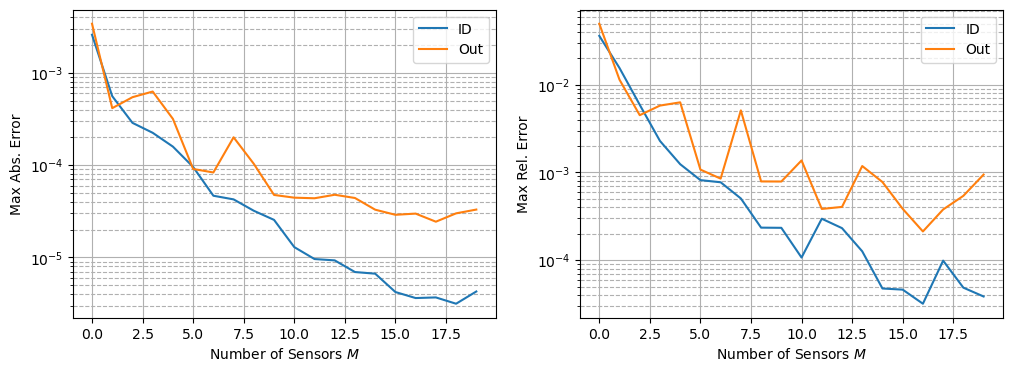

In [22]:
fig, axs = plt.subplots(1,2,figsize=(12, 4))

for strategy in xm_list.keys():
    axs[0].plot(maxAbsErr[strategy], label=strategy)
    axs[1].plot(maxRelErr[strategy], label=strategy)

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Number of Sensors $M$')
    ax.legend()
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')

axs[0].set_ylabel('Max Abs. Error')
axs[1].set_ylabel('Max Rel. Error')

Let us store the magic functions and sensors and the trained reduced coefficients.

In [23]:
import os
from pyforce.tools.write_read import StoreFunctionsList

path_offline = 'Results/GEIM_offline/'
os.makedirs(path_offline, exist_ok=True)

for strategy in xm_list.keys():
    StoreFunctionsList(domain, geim_offline[strategy].magic_fun, f'GEIM_{var_names[measured_field_i]}_{strategy}_mf',
                       filename = path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_mf')
    StoreFunctionsList(domain, geim_offline[strategy].magic_sens, f'GEIM_{var_names[measured_field_i]}_{strategy}_ms',
                       filename = path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_ms')
    
    np.savez_compressed(path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_TrainBeta.npz',
                        betaCoeff[strategy])

Let us plot the magic functions

[Text(0.5, 1.0, 'ID'), Text(0.5, 1.0, 'Out')]

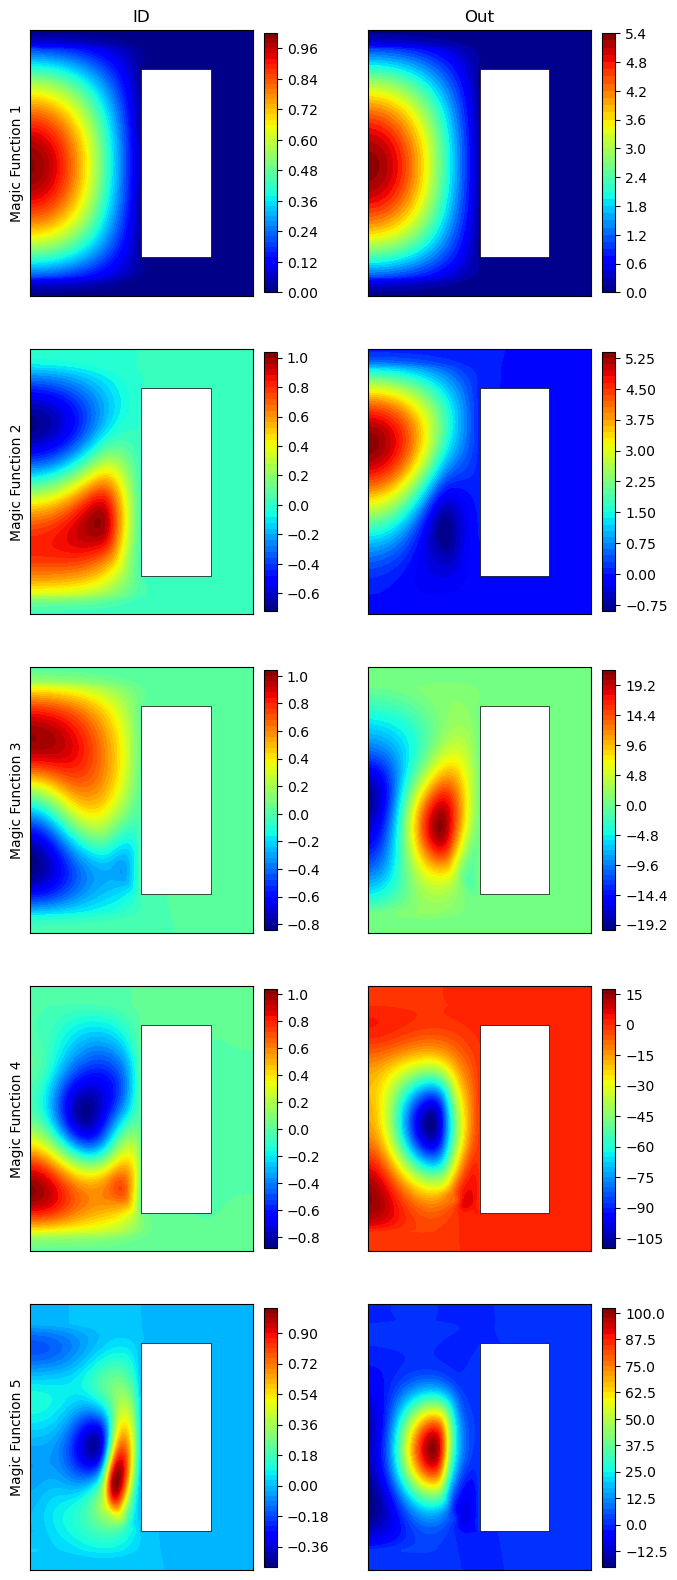

In [25]:
from utils import plot_contour

mf_to_plot = np.arange(0, 5, 1)

nrows = len(mf_to_plot)
ncols = len(xm_list.keys())

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

for row in range(nrows):
    for col, strategy in enumerate(xm_list.keys()):
        mf = geim_offline[strategy].magic_fun(mf_to_plot[row])
        cont = plot_contour(axs[row, col], 
                            np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 2]]).T, 
                            mf, levels=50)
        cbar = fig.colorbar(cont, ax=axs[row, col], fraction=0.046, pad=0.04)
    axs[row, 0].set_ylabel(f'Magic Function {mf_to_plot[row]+1}')

[axs[0, col].set_title(list(xm_list.keys())[col]) for col in range(ncols)]

Let us plot the magic sensors

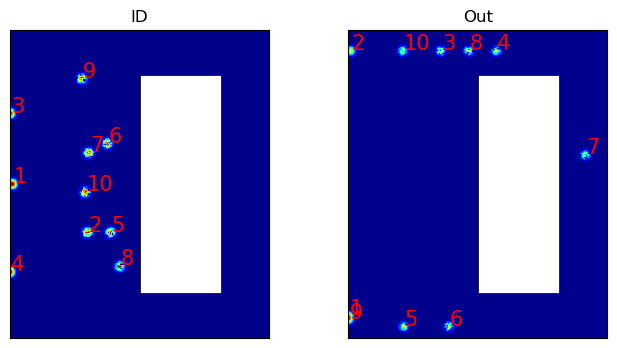

In [31]:
sens_to_plot = 10

fig, axs = plt.subplots(1, len(xm_list.keys()), figsize=(len(xm_list.keys())*4, 4))

for col, strategy in enumerate(xm_list.keys()):
    ms = np.zeros((train_snaps.fun_shape,))

    locs = list()

    for mm in range(sens_to_plot):
        ms += geim_offline[strategy].magic_sens(mm) / max(geim_offline[strategy].magic_sens(mm))
        locs.append(np.argmax(geim_offline[strategy].magic_sens(mm)))
    points = np.stack([domain.geometry.x[locs, 0], domain.geometry.x[locs, 2]]).T
    labels = [str(mm+1) for mm in range(sens_to_plot)]
    cont = plot_contour(axs[col], 
                        np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 2]]).T, 
                        ms, levels=50)
    axs[col].set_title(strategy)

    offset = 0.01
    for (x, y), label in zip(points, labels):
        axs[col].text(x + offset, y + offset, label, fontsize=15, color='red')


### Calculate the Lebesgue constant
Here the constant is calculated from the magic sensors and functions

In [32]:
from pyforce.offline.geim import computeLebesgue

lebesgue = dict()

for strategy in xm_list.keys():
    print(f'Computing Lebesgue constant for {strategy} strategy')
    lebesgue[strategy] = computeLebesgue(geim_offline[strategy].magic_fun, geim_offline[strategy].magic_sens)

Computing Lebesgue constant for ID strategy
Computing Lebesgue constant for Out strategy


Let us plot it against the number of sensors

Text(0, 0.5, 'Lebesgue constant $\\Lambda_M$')

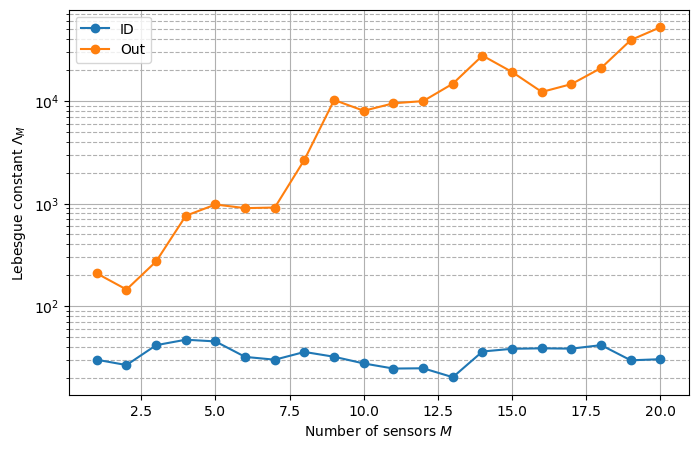

In [33]:
M_plot = np.arange(1, Mmax+1)

fig, axs = plt.subplots(figsize=(8,5))

for strategy in xm_list.keys():
    axs.plot(M_plot, lebesgue[strategy], 'o-', label=strategy)

axs.set_yscale('log')
axs.legend()
axs.grid(which='major', linestyle='-')
axs.grid(which='minor', linestyle='--')
axs.set_xlabel(r'Number of sensors $M$')
axs.set_ylabel(r'Lebesgue constant $\Lambda_M$')